# SVM MODEL Complete

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score, precision_score, recall_score, classification_report

from xgboost import XGBClassifier, XGBRegressor

# Importing the dataset  
dff = pd.read_csv('smart_grid_stability_augmented.csv')
df = dff.copy()
map1 = {'unstable': 0, 'stable': 1}
df['stabf'] = df['stabf'].replace(map1)
data = df.sample(frac=1)
#df = df.drop('stab', axis=1)
df.head()
df.isnull().sum()   # To make sure there are no null values
df.describe()        # summary of the data

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731,0.362000
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917,0.480583
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760,0.000000
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557,0.000000
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142,0.000000
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878,1.000000
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403,1.000000


c) Split the dataset into a training set and a test set.


In [11]:
# Training and Testing for SVM
# Features and target
df = df.iloc[:-45000].reset_index(drop=True)
X = df.drop(columns=['stabf','stab'], errors='ignore')
y = df['stabf']
# Split into training set (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 30% for testing
    random_state=42,     # for reproducibility
    stratify=y           # preserve class proportions
)

# Optional: view the shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")

X_train: (12000, 12), y_train: (12000,)
X_test:  (3000, 12),  y_test:  (3000,)


In [12]:
# Stratified 5-fold CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#(d) Linear SVM: vary C
Cs = [0.1,1,10]
errors_linear = []
for C in Cs:
    svc = SVC(kernel='linear', C=C)
    scores = cross_val_score(svc, X_train, y_train, cv=cv, scoring='accuracy')
    errors_linear.append(1 - scores.mean())

# 4) Pick best C and evaluate on TEST set
best_C = Cs[int(np.argmin(errors_linear))]
best_svc = SVC(kernel='linear', C=best_C).fit(X_train, y_train)
y_test_pred = best_svc.predict(X_test)
# Calculate accuracy
test_acc = best_svc.score(X_test, y_test)
# Compute metrics
acc  = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)   # for the “stable” class=1 by default
rec  = recall_score(y_test, y_test_pred)

print(f"Best C = {best_C}, validation CV error = {min(errors_linear):.3f}")
print(f"Test accuracy (held-out): {test_acc:.3f}")
print(f"Test Accuracy : {acc:.3f}")
print(f"Test Precision: {prec:.3f}")
print(f"Test Recall   : {rec:.3f}")

Best C = 0.1, validation CV error = 0.186
Test accuracy (held-out): 0.821
Test Accuracy : 0.821
Test Precision: 0.778
Test Recall   : 0.707


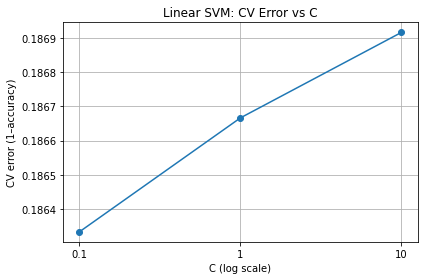

In [13]:
# Plot Linear CV error vs C
plt.figure(figsize=(6,4))
plt.plot(np.log10(Cs), errors_linear, marker='o')
plt.xticks(np.log10(Cs), Cs)
plt.xlabel('C (log scale)')
plt.ylabel('CV error (1–accuracy)')
plt.title('Linear SVM: CV Error vs C')
plt.grid(True)
plt.tight_layout()

In [5]:
#(e1) RBF SVM: vary C and gamma 
gammas = [ 0.1, 1, 10]
errors_rbf = np.zeros((len(gammas), len(Cs)))
for i, γ in enumerate(gammas):
    for j, C in enumerate(Cs):
        svc = SVC(kernel='rbf', C=C, gamma=γ)
        acc = cross_val_score(svc, X_train, y_train, cv=cv, scoring='accuracy').mean()
        errors_rbf[i, j] = 1 - acc

best_idx = np.unravel_index(np.argmin(errors_rbf), errors_rbf.shape)
best_gamma = gammas[best_idx[0]]
best_C_rbf = Cs[best_idx[1]]
print(f"Best hyperparameters → C = {best_C_rbf}, γ = {best_gamma}")

# 2) Retrain on full training set with those best hyperparameters
best_rbf = SVC(kernel='rbf', C=best_C_rbf, gamma=best_gamma, random_state=42)
best_rbf.fit(X_train, y_train)

# 3) Predict on the untouched test set
y_test_pred_rbf = best_rbf.predict(X_test)

# 4) Compute metrics
acc_rbf  = accuracy_score(y_test, y_test_pred_rbf)
prec_rbf = precision_score(y_test, y_test_pred_rbf)   # for positive class=1
rec_rbf  = recall_score(y_test, y_test_pred_rbf)

print(f"RBF‐SVM Test Accuracy : {acc_rbf:.3f}")
print(f"RBF‐SVM Test Precision: {prec_rbf:.3f}")
print(f"RBF‐SVM Test Recall   : {rec_rbf:.3f}")

Best hyperparameters → C = 10, γ = 0.1
RBF‐SVM Test Accuracy : 0.942
RBF‐SVM Test Precision: 0.916
RBF‐SVM Test Recall   : 0.924


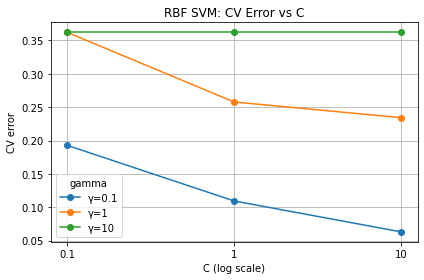

In [6]:
# 2) RBF: error vs log10(C) for each gamma
plt.figure(figsize=(6,4))
for i, γ in enumerate(gammas):
    plt.plot(np.log10(Cs), errors_rbf[i], marker='o', label=f'γ={γ}')
plt.xticks(np.log10(Cs), Cs)
plt.xlabel('C (log scale)')
plt.ylabel('CV error')
plt.title('RBF SVM: CV Error vs C')
plt.legend(title='gamma')
plt.grid(True)
plt.tight_layout()
